<a href="https://colab.research.google.com/github/MarcYu0303/Diffusion-Model/blob/main/diffusion_model_letterS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

shape of s_curve: (10000, 3)
shape of s_curve: (10000, 2)
torch.Size([10000, 2])


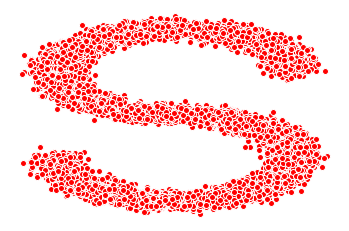

In [17]:
s_curve, _= make_s_curve(10**4, noise=0.1) # make_s_curve生成一万个点的s-curve
print('shape of s_curve:', np.shape(s_curve))
s_curve = s_curve[:, [0, 2]]/10.0
print('shape of s_curve:', np.shape(s_curve)) # 一万个样本，特征维度是2

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')
ax.axis('off')

dataset = torch.Tensor(s_curve).float()
print(dataset.shape)

In [3]:
num_steps = 100

# 制定每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
# print(betas)

alphas = 1 - betas
alphas_prob = torch.cumprod(alphas, 0) # alpha的连乘
alphas_prob_p = torch.cat([torch.tensor([1]).float(), alphas_prob[:-1]], 0) # previous alpha (alpha_t-1_prob)
alphas_bar_sqrt = torch.sqrt(alphas_prob)
one_minus_alphas_bar_log = torch.log(1 - alphas_prob)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prob)

assert alphas.shape == alphas_prob.shape == alphas_prob_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape
print('all the same shape:', betas.shape)


all the same shape: torch.Size([100])


In [4]:
# 计算任意时刻x的采样值，基于x_0和参数重整化
def q_t(x_0, t):
  noise = torch.randn_like(x_0) #正态分布中生成的随机噪声
  alphas_t = alphas_bar_sqrt[t]
  alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
  return (alphas_t * x_0 + alphas_1_m_t * noise)

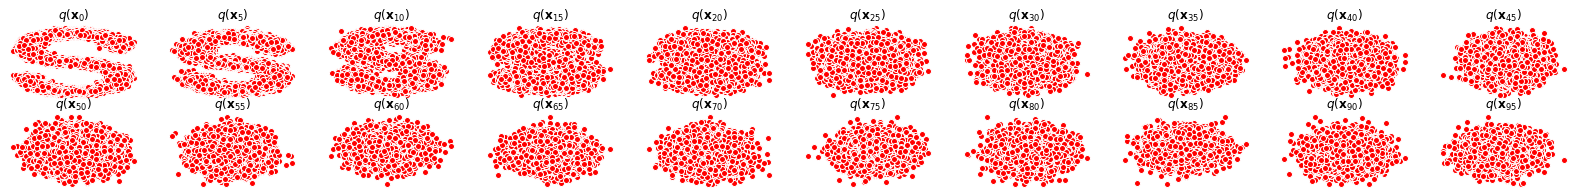

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

for i in range(num_shows):
  j = int(i/10)
  k = i%10

  q_i = q_t(dataset, torch.tensor([i*num_steps//num_shows]))
  axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')

  axs[j, k].set_axis_off()
  axs[j, k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

In [25]:
# 逆扩散过程
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):

  def __init__(self, n_steps, num_units=128):
    super(MLPDiffusion, self).__init__()

    self.linears = nn.ModuleList(
        [
          nn.Linear(2, num_units),
          nn.ReLU(),
          nn.Linear(num_units, num_units),
          nn.ReLU(),
          nn.Linear(num_units, num_units),
          nn.ReLU(),
          nn.Linear(num_units, 2),
        ]
    )
    self.step_embeddings = nn.ModuleList(
        [
          nn.Embedding(n_steps, num_units),
          nn.Embedding(n_steps, num_units),
          nn.Embedding(n_steps, num_units),
        ]
    )
  
  def forward(self, x_0, t):
    x = x_0
    for idx, embedding_layer in enumerate(self.step_embeddings):
      t_embedding = embedding_layer(t)
      x = self.linears[2*idx](x)
      x += t_embedding
      x = self.linears[2*idx+1](x)

    x = self.linears[-1](x)

    return x

训练的误差函数

In [16]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
  batch_size = x_0.shape[0]

  # 对一个batchsize随机生成时刻t
  t = torch.randint(0, n_steps, size=(batch_size//2,))
  t = torch.cat([t, n_steps-1-t], dim=0) #[batch_size]
  t = t.unsqueeze(-1) # [batch_size，1]

  # x0的系数
  a = alphas_bar_sqrt[t]

  # eps的系数
  am1 = one_minus_alphas_bar_sqrt[t]

  # 随机噪声eps
  e = torch.randn_like(x_0)

  # 模型输入
  x = a * x_0 + am1 * e

  # 送入模型，得到t时刻的随机噪声预测值
  output = model(x, t.squeeze(-1))

  # 与真实噪声一起计算误差，求得平均值
  return (e-output).square().mean()

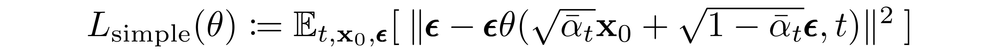

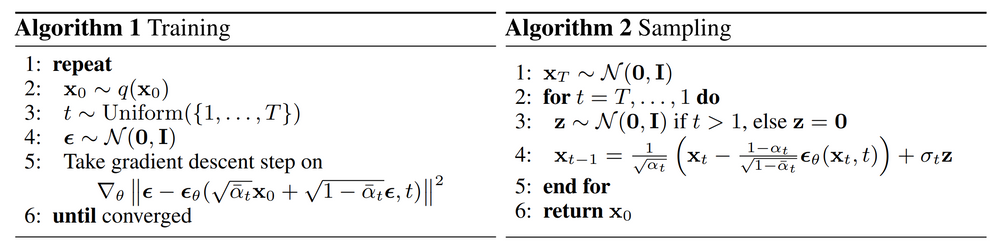

逆扩散采样函数

In [19]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
  """从x[T]恢复x[T-1], x[T-2], ..., x[0]"""

  cur_x = torch.randn(shape)
  x_seq = [cur_x]
  for i in reversed(range(n_steps)):
      cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
      x_seq.append(cur_x)
  return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
  """从x_T采样t时刻的重构值"""

  t = torch.tensor([t])
  coeff = betas[k] / one_minus_alphas_bar_sqrt[t]

  eps_theta = model(x,t)

  mean = (1 / (1-betas[t]).sqrt()) * (x - (coeff * eps_theta))

  z = torch.randn_like(x)
  sigma_t = betas[t].sqrt()

  sample = mean + sigma_t * z

  return (sample)

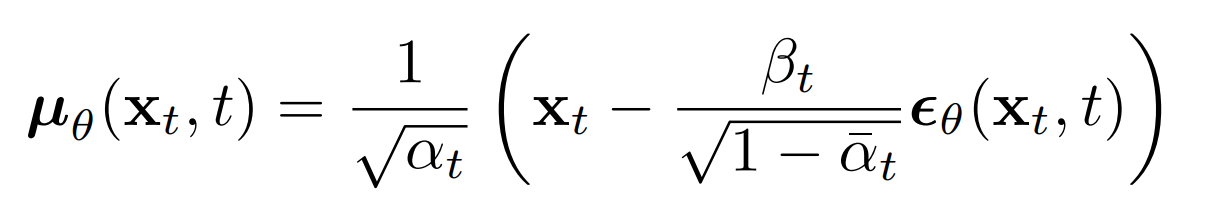

In [ ]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
  for idx, batch_x in enumerate(dataloader):
    loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.)
    optimizer.step()

  if (t % 100==0):
    print(loss)
    x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) # 采样一百个步骤的x sequence

    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(1, 11):
      cur_x = x_seq[i * 10].detach()
      axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
      axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  


tensor(0.5133, grad_fn=<MeanBackward0>)
tensor(0.4534, grad_fn=<MeanBackward0>)
tensor(0.2354, grad_fn=<MeanBackward0>)
tensor(0.2698, grad_fn=<MeanBackward0>)
tensor(0.3764, grad_fn=<MeanBackward0>)
tensor(0.3905, grad_fn=<MeanBackward0>)
tensor(0.2533, grad_fn=<MeanBackward0>)
tensor(0.1555, grad_fn=<MeanBackward0>)
tensor(0.3567, grad_fn=<MeanBackward0>)
tensor(0.2710, grad_fn=<MeanBackward0>)
tensor(0.2575, grad_fn=<MeanBackward0>)
tensor(0.1688, grad_fn=<MeanBackward0>)
